## Import Libraries

In [859]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import re
import nltk
from tqdm import tqdm
import random
import os

from string import punctuation
from collections import Counter

# textblob & vaderSentiment packages
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# scipy packages
from scipy import stats as st

# nltk packages
from nltk.corpus import stopwords, wordnet
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, RegexpTokenizer

# sklearn packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation


# gensim packages
from gensim.models import Word2Vec
import gensim.models.keyedvectors as word2vec

# tensorflow packages
import tensorflow as tf
from tensorflow import keras

# keras packages
from keras import layers
from keras.models import load_model

# spacy packages
import spacy
from spacy.util import minibatch
from spacy.training import Example


sns.set_theme()
warnings.simplefilter("ignore", category = RuntimeWarning)
warnings.simplefilter("ignore", category = UserWarning)
warnings.simplefilter("ignore", category = FutureWarning)

## Load Data

In [2]:
uber_df = pd.read_csv("Uber_Google_Play_Reviews.csv")

## Handle Missing Values

In [3]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

get_numerical_summary(uber_df).keys()

userName : 2 (0.0%)
content : 41 (0.008%)
reviewCreatedVersion : 72145 (14.429%)
replyContent : 480982 (96.196%)
repliedAt : 480982 (96.196%)
appVersion : 72145 (14.429%)


dict_keys(['userName', 'content', 'reviewCreatedVersion', 'replyContent', 'repliedAt', 'appVersion'])

In [4]:
# Drop unutilized columns
uber_df.drop(['Unnamed: 0', 'userImage', 'reviewId'], axis = 1, inplace = True)

# Drop rows with missing values
uber_df.drop(uber_df[uber_df.userName.isna()].index, inplace=True)
uber_df.drop(uber_df[uber_df.content.isna()].index, inplace=True)

get_numerical_summary(uber_df).keys()

reviewCreatedVersion : 72137 (14.429%)
replyContent : 480939 (96.196%)
repliedAt : 480939 (96.196%)
appVersion : 72137 (14.429%)


dict_keys(['reviewCreatedVersion', 'replyContent', 'repliedAt', 'appVersion'])

## Convert Data Types

In [5]:
# Get object features
obj_cols = uber_df.select_dtypes(include="object").keys()

obj_cols

Index(['userName', 'content', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')

In [6]:
# Function to define exact data types for each object feature
def open_object_dtype(df, cols):
    for col in cols:
        dtypes = set()

        for i in range(len(df)):
            dtypes.add(type(df[col].iloc[i]))

        print(col, ":", dtypes)

# Check original data types
open_object_dtype(uber_df, obj_cols)

userName : {<class 'str'>}
content : {<class 'str'>}
reviewCreatedVersion : {<class 'str'>, <class 'float'>}
at : {<class 'str'>}
replyContent : {<class 'str'>, <class 'float'>}
repliedAt : {<class 'str'>, <class 'float'>}
appVersion : {<class 'str'>, <class 'float'>}


In [7]:
# Convert data types
uber_df['at'] = pd.to_datetime(uber_df['at'])
uber_df['repliedAt'] = pd.to_datetime(uber_df['repliedAt'])
uber_df['content'] = uber_df['content'].astype(str)

In [8]:
# 0-10 scaling
uber_df['score'] = uber_df['score'] * 2

uber_df['score']

0          2
1         10
2         10
3          2
4         10
          ..
499995     6
499996    10
499997    10
499998     2
499999    10
Name: score, Length: 499957, dtype: int64

In [9]:
uber_df['isReply'] = True
uber_df.isReply = uber_df['replyContent'].isna()

uber_df['isReply'].value_counts()

True     480939
False     19018
Name: isReply, dtype: int64

## Clean Text

In [10]:
# Download nltk data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
contractions_dict = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "iit will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [12]:
# ----------Remove emoji-----------
def remove_emoji(string):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)
    return re.sub(emoji_pattern, '', string)


# -----------Contractions expend-----------
# ex: I'm -> I am, I'll -> I will,...
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def cons(text):
    text = expand_contractions(text,contractions_dict)
    return text


# -----------To lowercase-----------
def to_lower(text):
    return ' '.join([w.lower() for w in word_tokenize(text)])


# -----------Remove special characters-----------
def clean_text(text, remove_digits = True):
    text = re.sub(r"[^a-zA-z0-9\s]"," ",text)
    return text


# -----------Remove punctuation-----------
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)


# -----------Replace all elongated words-----------
# ex: Sooooo -> so, gooooooood -> good,...
def replace_elongated(word):

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:
        return replace_elongated(repl_word)
    else:
        return repl_word

def replace_elongated_words(text):
    finalTokens = []
    tokens = nltk.word_tokenize(text)
    for w in tokens:
        finalTokens.append(replace_elongated(w))
    text = " ".join(finalTokens)
    return text


# Remove Stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    no_stopword_text = [w for w in text if not w in stop_words]
    return no_stopword_text


# Stemming
stemmer = SnowballStemmer("english")
def stemming(text_list):
    stemSentence = []
    for word in text_list:
        stemSentence.append(stemmer.stem(word))

    return stemSentence


# Drop number
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

In [13]:
uber_df['content'] = uber_df['content'].apply(remove_emoji)
uber_df['content'] = uber_df['content'].apply(cons)
uber_df['content'] = uber_df['content'].apply(to_lower)
uber_df['content'] = uber_df['content'].apply(clean_text)
uber_df['content'] = uber_df['content'].apply(strip_punctuation)
uber_df['content'] = uber_df['content'].apply(replace_elongated_words)
uber_df['content'] = uber_df['content'].apply(lambda x: RegexpTokenizer(r'\w+').tokenize(x)) # Tokenization
uber_df['content'] = uber_df['content'].apply(remove_stopwords)
uber_df['content'] = uber_df['content'].apply(stemming)
uber_df['content'] = uber_df['content'].apply(drop_numbers)

## Descriptive Statistics
### Numeric Columns

In [14]:
# Get numeric columns
num_cols = uber_df.select_dtypes(include = 'number').columns

num_cols

Index(['score', 'thumbsUpCount'], dtype='object')

In [15]:
# Functions to calculate missing ratio and missing count
def missing_ratios(x):
    return (x.isna().mean()*100)
def missing_values(x):
    return (x.isna().sum().T)

missing_num_df = uber_df.select_dtypes(include = "number").agg(func = [missing_ratios, missing_values])


# Add more aggregates to Descriptive Statitics
median = []
ranges = []
skew = []
var = []
kurtosis = []
iqr = []
modes = []

for col in num_cols:
    modes.append(st.mode(uber_df[col]))
    iqr.append(uber_df[col].quantile(.75) - uber_df[col].quantile(.25))
    ranges.append(uber_df[col].max() - uber_df[col].min())
    skew.append(uber_df[col].skew())
    var.append(uber_df[col].var())
    kurtosis.append(uber_df[col].kurtosis())

list = [modes, iqr, ranges, skew, var, kurtosis]
agg_df = pd.DataFrame(data = list, columns = num_cols)
agg_df.index = ['mode', 'iqr', 'range', 'skew', 'var', 'kurtosis']


# Merge calculated paramaters
summary_num_df = pd.concat([missing_num_df, uber_df.describe(), agg_df])
summary_num_df

,score,thumbsUpCount
missing_ratios,0.0,0.0
missing_values,0.0,0.0
count,499957.0,499957.0
mean,7.501981,0.798641
std,3.456756,18.594379
min,2.0,0.0
25%,2.0,0.0
50%,10.0,0.0
75%,10.0,0.0
max,10.0,4441.0


### Category Columns

In [16]:
# Get category columns
cat_cols = uber_df.select_dtypes(include = "object").columns.to_list()

cat_cols

['userName', 'content', 'reviewCreatedVersion', 'replyContent', 'appVersion']

In [17]:
pd.set_option('display.max_colwidth', 300)

# Merge calculated paramaters
missing_cat_df = uber_df.select_dtypes(include = "object").agg(func = [missing_ratios, missing_values])
summary_cat_df = pd.concat([missing_cat_df, uber_df[cat_cols].describe()])

summary_cat_df

,userName,content,reviewCreatedVersion,replyContent,appVersion
missing_ratios,0.0,0.0,14.428641,96.196073,14.428641
missing_values,0.0,0.0,72137.0,480939.0,72137.0
count,499957,499957,427820,19018,427820
unique,449414,264438,475,13080,475
top,A Google user,good,4.451.10003,"Hi, we're extremely sorry to hear about your concern regarding your recent experience.\nThis is certainly something we'd want to deep dive into. For us to be able to resolve your recent interaction with us, fill in your details here: https://bit.ly/343HNsE. We shall get back to you at the earliest.",4.451.10003
freq,1364,55012,15440,726,15440


## Data Visualization
### Time Series Analysis

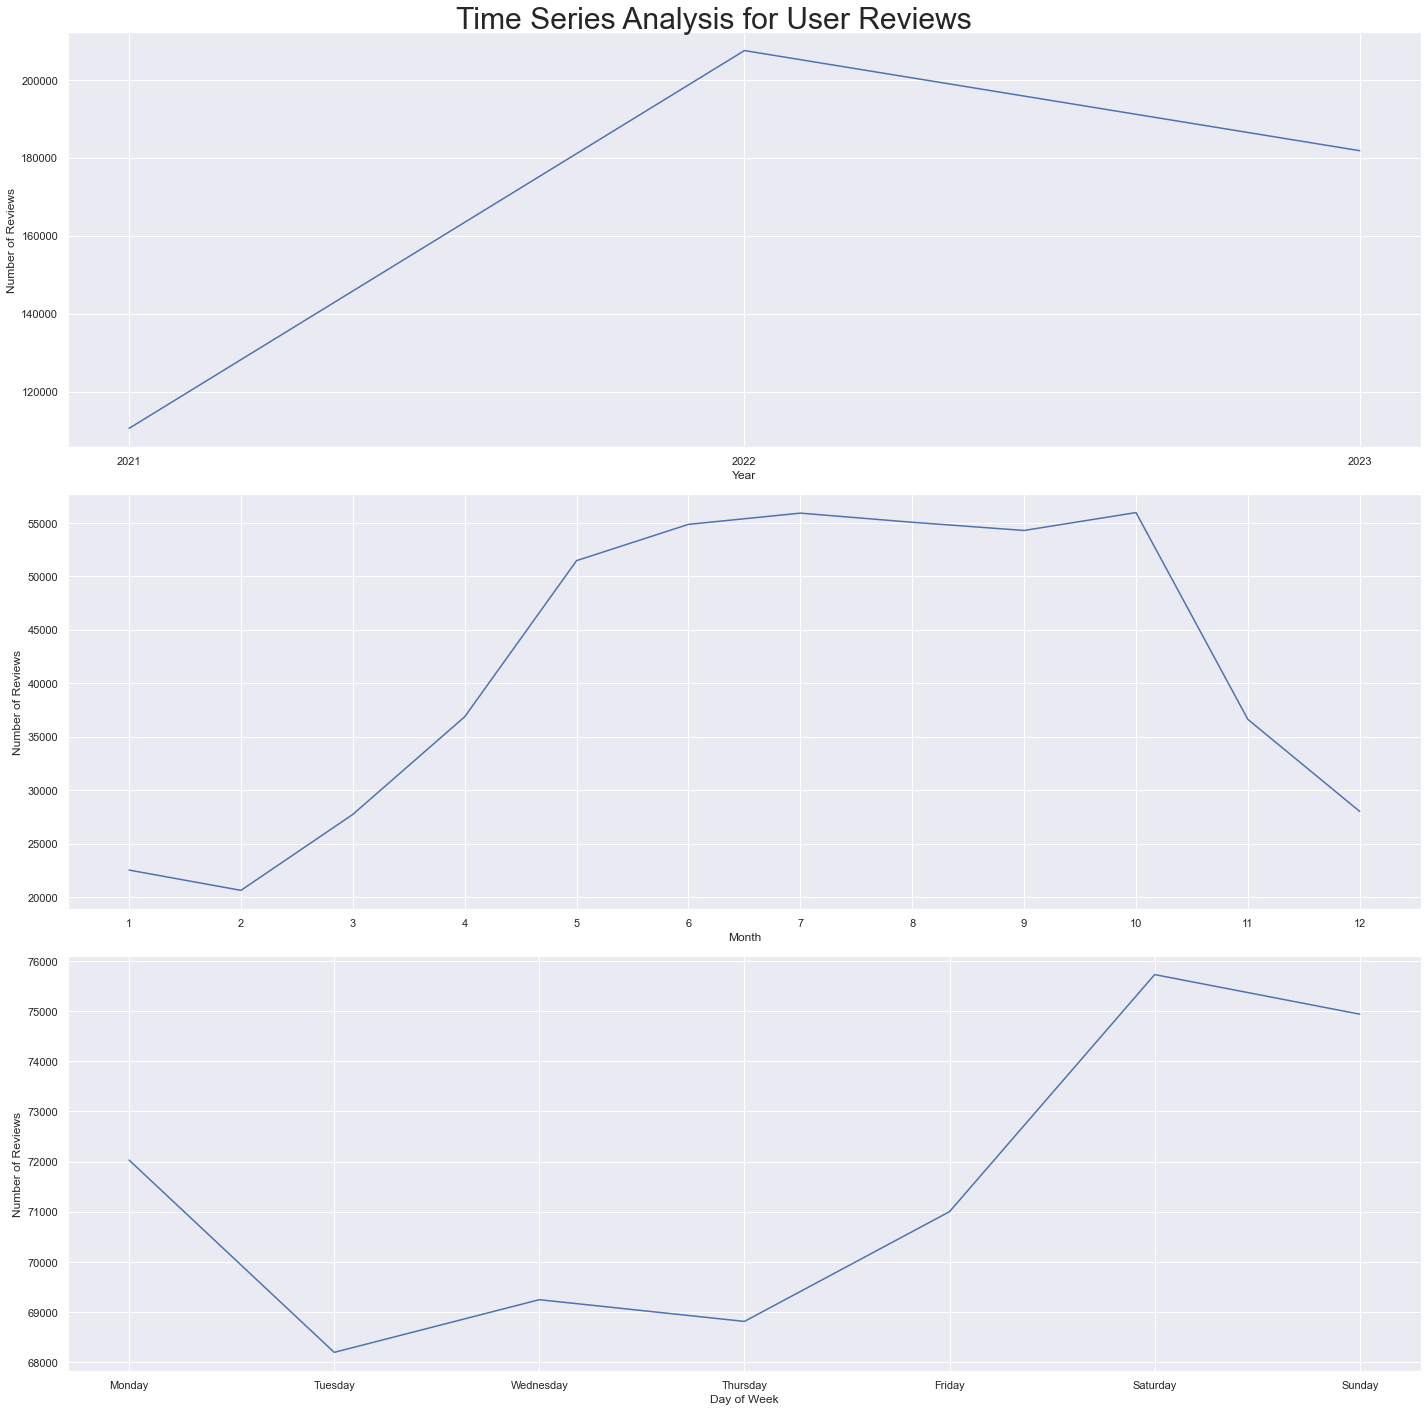

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

# Comparison by Year
sns.lineplot(data=uber_df.groupby(uber_df['at'].dt.year).size(), ax=axes[0])
axes[0].set_xlabel("Year")
axes[0].set_ylabel('Number of Reviews')
axes[0].set_xticks(uber_df['at'].dt.year.unique())


# Comparison by Month
sns.lineplot(data=uber_df.groupby(uber_df['at'].dt.month).size(), ax=axes[1])
axes[1].set_xlabel("Month")
axes[1].set_ylabel('Number of Reviews')
axes[1].set_xticks(uber_df['at'].dt.month.unique())


# Comparison by Day of Week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.lineplot(data=uber_df.groupby(uber_df['at'].dt.day_name()).size().reindex(days), ax=axes[2])
axes[2].set_xlabel("Day of Week")
axes[2].set_ylabel('Number of Reviews')
axes[2].set_xticks(days)



fig.suptitle("Time Series Analysis for User Reviews", fontsize = 30)
fig.tight_layout()
fig.savefig("User.png")

plt.show()

### Ratings Distribution

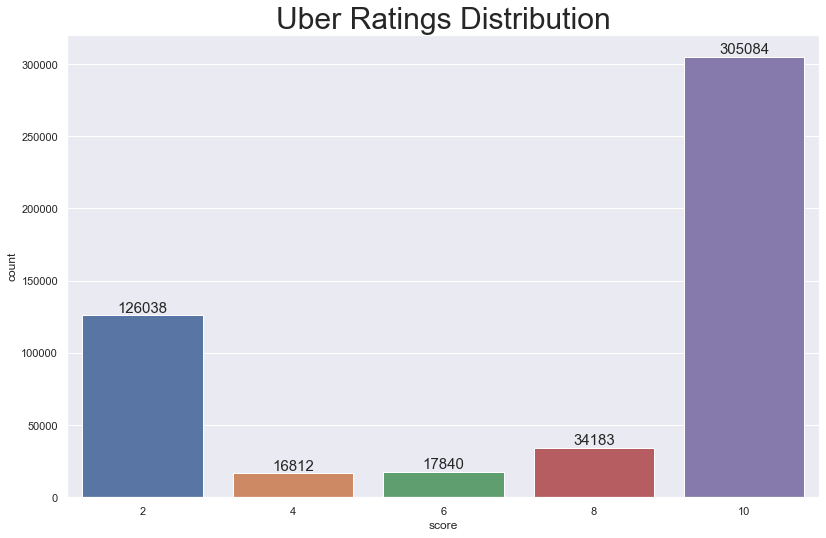

In [19]:
# Barplot
fig, ax = plt.subplots(figsize = (12, 8))
sns.set(font_scale = 2)

sns.countplot(x = 'score', data = uber_df)
ax.bar_label(ax.containers[0], fmt='%.0f', fontsize = 15)

plt.title("Uber Ratings Distribution", fontsize = 30)
plt.tight_layout()
plt.show()

### WordCloud for reviews

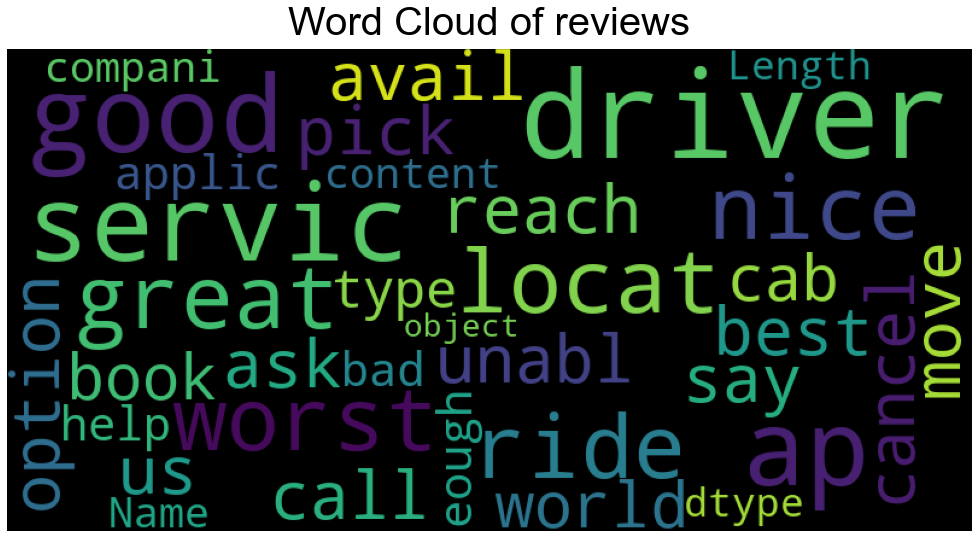

In [20]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(16, 8),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=800,
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = WordCloud.ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})

    plt.axis('off');
    plt.tight_layout()

plot_wordcloud(uber_df['content'], title="Word Cloud of reviews")

## Data Modeling
### TextBlob

In [ ]:
def get_sentiment_TextBlob(text):
    analysis = TextBlob(str(text))
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

uber_df['sentiment_TextBlob'] = uber_df['content'].apply(get_sentiment_TextBlob)

### VADER

In [ ]:
analyser = SentimentIntensityAnalyzer()
def get_sentiment_VADER(text):
    score = analyser.polarity_scores(text)['compound']
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

uber_df['sentiment_Vader'] = uber_df['content'].apply(get_sentiment_VADER)

### Multinomial Naive Bayers

In [24]:
X = uber_df['content']
y = uber_df['score']

# Convert ratings to binary (rating > 3: positive; rating < 3: negative)
y = (y > 6).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)


print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 399965
Test size: 99992


In [25]:
# Create a Bag-of-Words representation of the text data
count_vectorizer = CountVectorizer()
X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

In [26]:
# Create and train model
MNB = MultinomialNB()
MNB.fit(X_train_vectorized, y_train)

MultinomialNB()

In [27]:
# Make predictions on the testing data
y_pred = MNB.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9184934794783582
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87     32138
           1       0.94      0.94      0.94     67854

    accuracy                           0.92     99992
   macro avg       0.91      0.90      0.91     99992
weighted avg       0.92      0.92      0.92     99992



In [28]:
# MultinomialNB method
def get_sentiment_MultinomialNB(text, score):

    # By reviews
    if text.strip():
        new_text = text.split(',')
        new_text_vectorized = count_vectorizer.transform(new_text)
        predicted_sentiment = MNB.predict(new_text_vectorized)

        if predicted_sentiment[0] == 1:
            return 'Positive'
        else:
            return 'Negative'

    # By ratings if string is blank
    else:
        if score > 6:
            return 'Positive'
        elif score < 6:
            return 'Negative'
        else:
            return 'Neutral'

uber_df['sentiment_MNB'] = uber_df.apply(lambda x: get_sentiment_MultinomialNB(x['content'], x['score']), axis = 1)

### Logistic Regression & TF-IDF
#### TF-IDF

In [29]:
def get_tfidf_features(train_fit, ngrams=(1,1)):
    vector = TfidfVectorizer(ngram_range=ngrams, sublinear_tf=True)
    vector.fit(train_fit)
    return vector

In [30]:
# Create a Bag-of-Words representation of the text data
tfidf_vectorizer = get_tfidf_features(uber_df['content'])
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_test_transformer = tfidf_vectorizer.transform(X_test)

#### Logistic Regression

In [31]:
# Create a train model
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train_vectorized, y_train)

LogisticRegression()

In [32]:
# Make predictions on the testing data
y_pred = LR.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9265741259300744
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89     32138
           1       0.95      0.94      0.95     67854

    accuracy                           0.93     99992
   macro avg       0.92      0.92      0.92     99992
weighted avg       0.93      0.93      0.93     99992



In [33]:
# Logistic Regression method
def get_sentiment_LR(text, score):

    # By reviews
    if text.strip():
        new_text = text.split(',')
        new_text_vectorized = tfidf_vectorizer.transform(new_text)
        predicted_sentiment = LR.predict(new_text_vectorized)

        if predicted_sentiment[0] == 1:
            return 'Positive'
        else:
            return 'Negative'

    # By ratings if string is blank
    else:
        if score > 6:
            return 'Positive'
        elif score < 6:
            return 'Negative'
        else:
            return 'Neutral'

uber_df['sentiment_LR'] = uber_df.apply(lambda x: get_sentiment_LR(x['content'], x['score']), axis = 1)

### Word2Vec & CNN
#### Word2Vec

In [35]:
# 20000:5000 = 8:2
reviews = X_train[:20000]
labels = y_train[:20000]

test_reviews = X_test[:5000]
test_labels = y_test[:5000]

print("Train size:", len(reviews))
print("Test size:", len(test_reviews))

Train size: 20000
Test size: 5000


In [36]:
print("Number of blank comments before replacement", len([review for review in reviews if review == '']))

reviews = ['...' if review == '' else review for review in reviews]
print("Number of blank comments after replacement:", len([review for review in reviews if review == '']))

Number of blank comments before replacement 396
Number of blank comments after replacement: 0


In [37]:
input_gensim = []

for review in reviews:
    input_gensim.append(str(review).split())

In [38]:
w2v = Word2Vec(input_gensim, vector_size=128, window=5, min_count=0, workers=4, sg=1)
w2v.wv.save(".\\pretrained_models\\CNN\\word.model")

(array([1.588e+04, 2.205e+03, 8.480e+02, 5.370e+02, 4.040e+02, 9.200e+01,
        1.000e+01, 1.400e+01, 4.000e+00, 6.000e+00]),
 array([ 1. , 10.6, 20.2, 29.8, 39.4, 49. , 58.6, 68.2, 77.8, 87.4, 97. ]),
 <BarContainer object of 10 artists>)

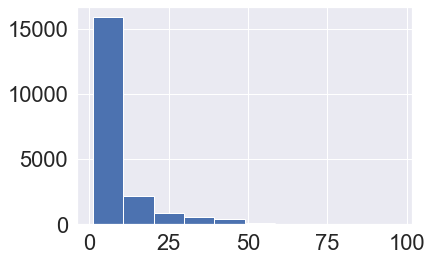

In [39]:
seq_len = [len(input) for input in input_gensim]

plt.hist(seq_len, bins=10)

In [40]:
w2v_model = word2vec.KeyedVectors.load(".\\pretrained_models\\CNN\\word.model")

word_labels = []
max_seq = 100
embedding_size = 128

for word in w2v_model.index_to_key:
    word_labels.append(word)

def reviews_embedding(comment):
    matrix = np.zeros((max_seq, embedding_size))
    words = str(comment).split()
    lencmt = len(words)

    for i in range(max_seq):
        indexword = i % lencmt
        if (max_seq - i < lencmt):
            break
        if(words[indexword] in word_labels):
            matrix[i] = w2v_model[words[indexword]]
    matrix = np.array(matrix)
    return matrix

In [41]:
train_data = []
label_data = []

for x in tqdm(reviews):
    train_data.append(reviews_embedding(x))
train_data = np.array(train_data)

for y in tqdm(labels):
    label_ = np.zeros(2)
    try:
        label_[int(y)] = 1
    except:
        label_[0] = 1
    label_data.append(label_)

100%|██████████| 20000/20000 [00:00<00:00, 346752.76it/s]


#### CNN

In [42]:
sequence_length = 100
embedding_size = 128
num_classes = 3
filter_sizes = 3
num_filters = 150
epochs = 100
batch_size = 30
learning_rate = 0.01
dropout_rate = 0.5

In [43]:
x_train = train_data.reshape(train_data.shape[0], sequence_length, embedding_size, 1).astype('float32')
y_train = np.array(label_data)

# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(num_filters, (filter_sizes, embedding_size),
                        padding='valid',
                        input_shape=(sequence_length, embedding_size, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(98, 1)))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))


# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 1, 150)        57750     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 150)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 1, 150)         0         
                                                                 
 flatten (Flatten)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 100)               15100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                        

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.2)
history = model.fit(x = X_train, y = Y_train, batch_size = batch_size, verbose=1, epochs=epochs, validation_data=(X_test, Y_test))

model.save(".\\pretrained_models\\CNN\\model.h5")

Epoch 1/100
534/534 [==============================] - 14s 17ms/step - loss: 0.2923 - accuracy: 0.8885 - val_loss: 0.2430 - val_accuracy: 0.9057
Epoch 2/100
534/534 [==============================] - 9s 16ms/step - loss: 0.2654 - accuracy: 0.9001 - val_loss: 0.2381 - val_accuracy: 0.9095
Epoch 3/100
534/534 [==============================] - 9s 16ms/step - loss: 0.2601 - accuracy: 0.9019 - val_loss: 0.2376 - val_accuracy: 0.9080
Epoch 4/100
534/534 [==============================] - 9s 16ms/step - loss: 0.2540 - accuracy: 0.9064 - val_loss: 0.2419 - val_accuracy: 0.9075
Epoch 5/100
534/534 [==============================] - 9s 16ms/step - loss: 0.2490 - accuracy: 0.9064 - val_loss: 0.2374 - val_accuracy: 0.9107
Epoch 6/100
534/534 [==============================] - 9s 17ms/step - loss: 0.2493 - accuracy: 0.9062 - val_loss: 0.2366 - val_accuracy: 0.9112
Epoch 7/100
534/534 [==============================] - 9s 16ms/step - loss: 0.2469 - accuracy: 0.9069 - val_loss: 0.2400 - val_accuracy

#### Test Model

In [45]:
model_sentiment = load_model(".\\pretrained_models\\CNN\\model.h5")

In [46]:
print("Number of blank comments before replacement", len([review for review in test_reviews if review == '']))

test_reviews = ['...' if review == '' else review for review in test_reviews]
print("Number of blank comments after replacement:", len([review for review in test_reviews if review == '']))

Number of blank comments before replacement 88
Number of blank comments after replacement: 0


In [47]:
reviews_for_test = []
labels_for_test = []

for x in tqdm(test_reviews):
    reviews_for_test.append(reviews_embedding(x))
reviews_for_test = np.array(reviews_for_test)

for y in tqdm(test_labels):
    label_ = np.zeros(2)
    try:
        label_[int(y)] = 1
    except:
        label_[0] = 1
    labels_for_test.append(np.array(label_))
label_for_test = np.array(labels_for_test)

  4%|▎         | 175/5000 [00:00<00:05, 871.64it/s]

100%|██████████| 5000/5000 [00:00<00:00, 452518.56it/s]


In [48]:
result = []
for sent in reviews_for_test:
    maxtrix_embedding = np.expand_dims(sent, axis=0)
    maxtrix_embedding = np.expand_dims(maxtrix_embedding, axis=3)
    result.append(np.argmax(model_sentiment.predict(maxtrix_embedding)))

1/1 [==============================] - 0s 25ms/step


In [49]:
# Evaluate the model
accuracy = accuracy_score(test_labels, result)
report = classification_report(test_labels, result)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.908
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      1572
           1       0.94      0.93      0.93      3428

    accuracy                           0.91      5000
   macro avg       0.89      0.90      0.89      5000
weighted avg       0.91      0.91      0.91      5000



In [50]:
W2V_CNN_model = load_model("model.h5")

# Word2Vec & CNN method
def get_sentiment_Word2Vec_CNN(text, score):

    # By reviews
    if text.strip():
        new_text = text.split(',')
        review_vector = np.array(reviews_embedding(new_text))

        maxtrix_embedding = np.expand_dims(review_vector, axis=0)
        maxtrix_embedding = np.expand_dims(maxtrix_embedding, axis=3)

        predicted_sentiment = np.argmax(W2V_CNN_model.predict(maxtrix_embedding))

        if predicted_sentiment == 1:
            return 'Positive'
        else:
            return 'Negative'

    # By ratings if string is blank
    else:
        if score > 6:
            return 'Positive'
        elif score < 6:
            return 'Negative'
        else:
            return 'Neutral'

#uber_df['sentiment_W2V_CNN'] = uber_df.apply(lambda x: get_sentiment_Word2Vec_CNN(x['content'], x['score']), axis = 1)

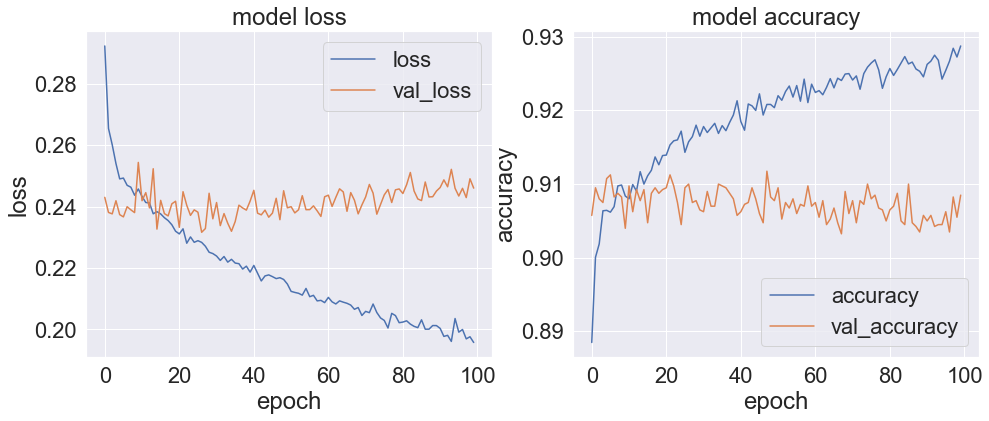

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

loss = history.history['loss']
val_loss = history.history['val_loss']
ax[0].plot(loss)
ax[0].plot(val_loss)
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['loss', 'val_loss'])


accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
ax[1].plot(accuracy)
ax[1].plot(val_accuracy)
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['accuracy', 'val_accuracy'])


plt.show()

### spaCy

In [52]:
#pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [53]:
nlp = spacy.blank('en')

# Add the TextCategorizer to the empty model
textcat = nlp.add_pipe("textcat")

# add label to text classifier
textcat.add_label("Positive")
textcat.add_label("Negative")

# print out labels
textcat.labels

('Positive', 'Negative')

In [54]:
del list

In [55]:
X = uber_df['content']
y = uber_df['score']

# Convert ratings to binary (rating > 3: positive; rating < 3: negative)
y = (y > 6).astype(int)

# Prepare training data
train_texts = X.values
train_labels = [{'cats': {'Positive': label == 1,
                          'Negative': label == 0}} 
                for label in y]

train_data = list(map(list, zip(train_texts[:20000], train_labels[:20000])))
train_data[:5]

[['worst servic ever driver pick ride driver ask us cancel ride driver say unabl reach locat driver move locat call option avail',
  {'cats': {'Positive': False, 'Negative': True}}],
 ['great ap', {'cats': {'Positive': True, 'Negative': False}}],
 ['nice best ap world book cab type',
  {'cats': {'Positive': True, 'Negative': False}}],
 ['worst applic ever', {'cats': {'Positive': False, 'Negative': True}}],
 ['great', {'cats': {'Positive': True, 'Negative': False}}]]

In [56]:
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

# Create the batch generator with batch size = 8
batches = minibatch(train_data, size = 8)

# Iterate through minibatches
for batch in batches:
    # Each batch is a list of (text, label) 
    for text, labels in batch:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, labels)
        nlp.update([example], sgd = optimizer)

In [57]:
random.seed(1)
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {}
for epoch in range(10):
    random.shuffle(train_data)
    # Create the batch generator with batch size = 8
    batches = minibatch(train_data, size = 8)
    
    # Iterate through minibatches
    for batch in batches:
        for text, labels in batch:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, labels)
            nlp.update([example], sgd = optimizer, losses = losses)
    print(losses)

{'textcat': 3095.2570582735484}
{'textcat': 5521.909591188941}
{'textcat': 7729.495505497308}
{'textcat': 9752.271995210951}
{'textcat': 11620.733500453207}
{'textcat': 13372.075554232006}
{'textcat': 15050.766685282038}
{'textcat': 16697.429849692493}
{'textcat': 18236.930854481267}
{'textcat': 19783.52132968488}


In [58]:
# save model
nlp.to_disk(".\\pretrained_models\\spaCy")

In [614]:
# load previous spaCy model
NLP = spacy.load(os.getcwd())

# Spacy method
def get_sentiment_spaCy(sentences):
    doc = [NLP.tokenizer(text) for text in sentences]
    
    # Use textcat to get the scores for each doc
    textcat = NLP.get_pipe('textcat')
    scores = textcat.predict(doc)

    # From the scores, find the label with the highest score/probability
    predicted_labels = scores.argmax(axis = 1)
    res = [textcat.labels[label] for label in predicted_labels]

    return res

#uber_df['sentiment_spaCy'] = get_sentiment_spaCy(uber_df['content'][0:500000])

## Model Evaluation

### Result

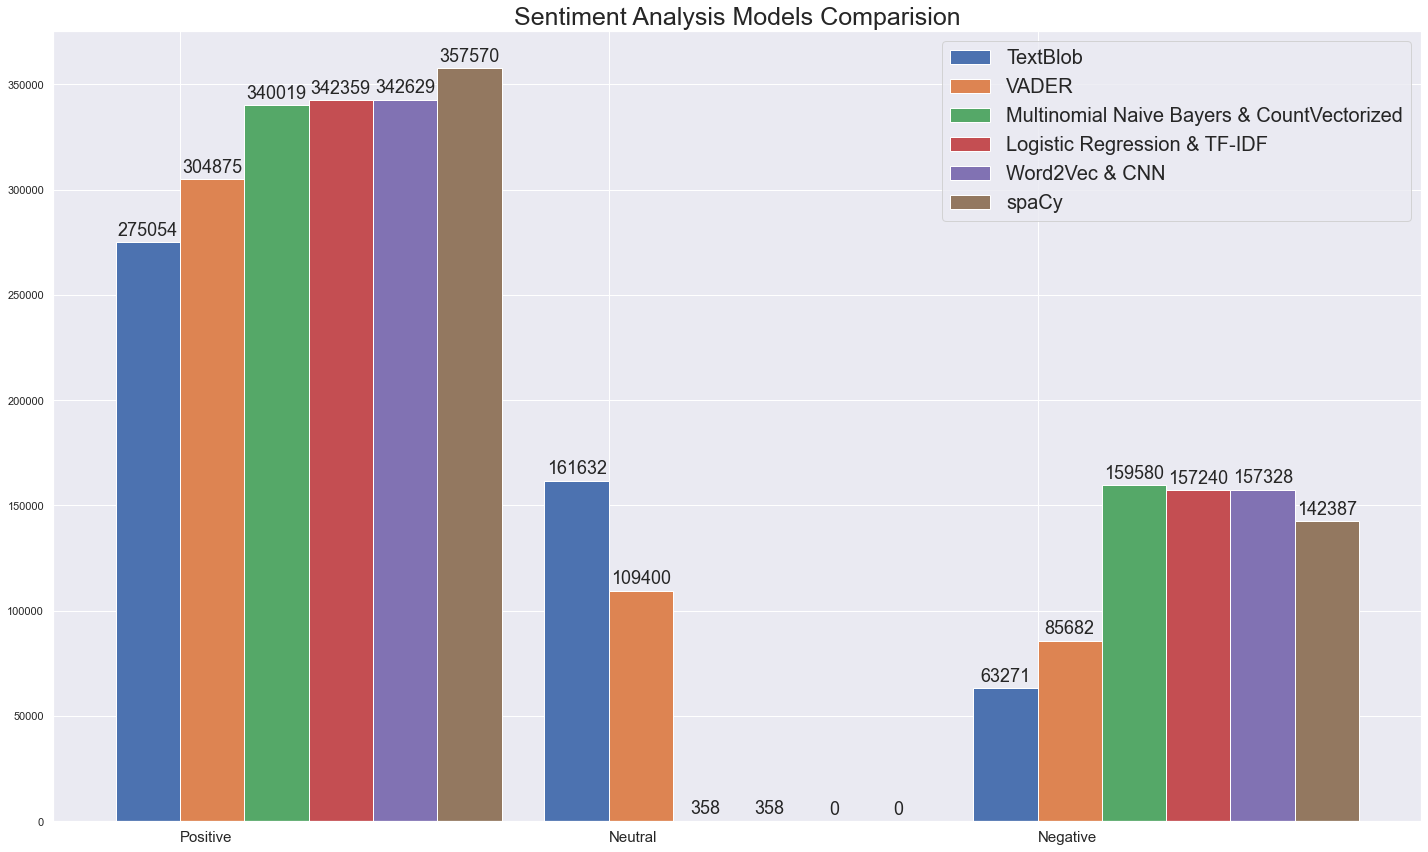

In [846]:
labels = ['Positive', 'Neutral', 'Negative']
textblob = []
vader = []
multinomialNB = []
logit = []
spacy = []
w2v_cnn = []

for i in labels:
    textblob.append(uber_df[uber_df['sentiment_TextBlob'] == i].shape[0])
    vader.append(uber_df[uber_df['sentiment_Vader'] == i].shape[0])
    multinomialNB.append(uber_df[uber_df['sentiment_MNB'] == i].shape[0])
    logit.append(uber_df[uber_df['sentiment_LR'] == i].shape[0])
    w2v_cnn.append(uber_df[uber_df['sentiment_W2V_CNN'] == i].shape[0])
    spacy.append(uber_df[uber_df['sentiment_spaCy'] == i].shape[0])
    

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize = (20, 12))
rects1 = ax.bar(x - width/2, textblob, width, label = 'TextBlob')
rects2 = ax.bar(x + width/2, vader, width, label = 'VADER')
rects3 = ax.bar(x + width/2 + 0.15, multinomialNB, width, label = 'Multinomial Naive Bayers & CountVectorized')
rects4 = ax.bar(x + width/2 + 0.3, logit, width, label = 'Logistic Regression & TF-IDF')
rects5 = ax.bar(x + width/2 + 0.45, w2v_cnn, width, label = 'Word2Vec & CNN')
rects6 = ax.bar(x + width/2 + 0.6, spacy, width, label = 'spaCy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Sentiment Analysis Models Comparision', fontsize = 25)


# set amounts
ax.bar_label(rects1, padding = 3, fontsize = 18)
ax.bar_label(rects2, padding = 3, fontsize = 18)
ax.bar_label(rects3, padding = 3, fontsize = 18)
ax.bar_label(rects4, padding = 3, fontsize = 18)
ax.bar_label(rects5, padding = 3, fontsize = 18)
ax.bar_label(rects6, padding = 3, fontsize = 18)

ax.set_xticks(x)
ax.set_xticklabels(labels, ha = 'left', fontsize = 15)

# PLOT
ax.legend(fontsize = 20)

fig.tight_layout()
fig.savefig("Sentiment_Analysis_Comparision")
plt.show()

### Metric

In [701]:
def get_sentiment_by_score(score):
        # By ratings if string is blank
    if score > 6:
        return 'Positive'
    elif score < 6:
        return 'Negative'
    else:
        return 'Neutral'
    
y_true = uber_df['score'].apply(get_sentiment_by_score)
labels = ['Positive', 'Neutral', 'Negative']

In [700]:
accuracy_textblob = accuracy_score(y_true, uber_df.sentiment_TextBlob).round(2)
accuracy_vader = accuracy_score(y_true, uber_df.sentiment_Vader).round(2)
accuracy_MNB = accuracy_score(y_true, uber_df.sentiment_MNB).round(2)
accuracy_LR = accuracy_score(y_true, uber_df.sentiment_LR).round(2)
accuracy_CNN = accuracy_score(y_true, uber_df.sentiment_W2V_CNN).round(2)
accuracy_spaCy = accuracy_score(y_true, uber_df.sentiment_spaCy).round(2)

In [725]:
def plot(y_true, y_pred, row, col, model_name, accuracy):
    cm1 = confusion_matrix(y_true, y_pred, normalize = 'all')
    sns.heatmap(cm1, annot = True, ax = axes[row][col], cmap = "Blues", fmt='.2f')
    # labels
    axes[row][col].set_xlabel('Predicted labels')
    axes[row][col].set_ylabel('Observed labels')
    # ticks
    axes[row][col].xaxis.set_ticklabels(labels)
    axes[row][col].yaxis.set_ticklabels(labels)
    # title
    axes[row][col].set_title(model_name + " (acc = " + accuracy.astype(str) + ")")

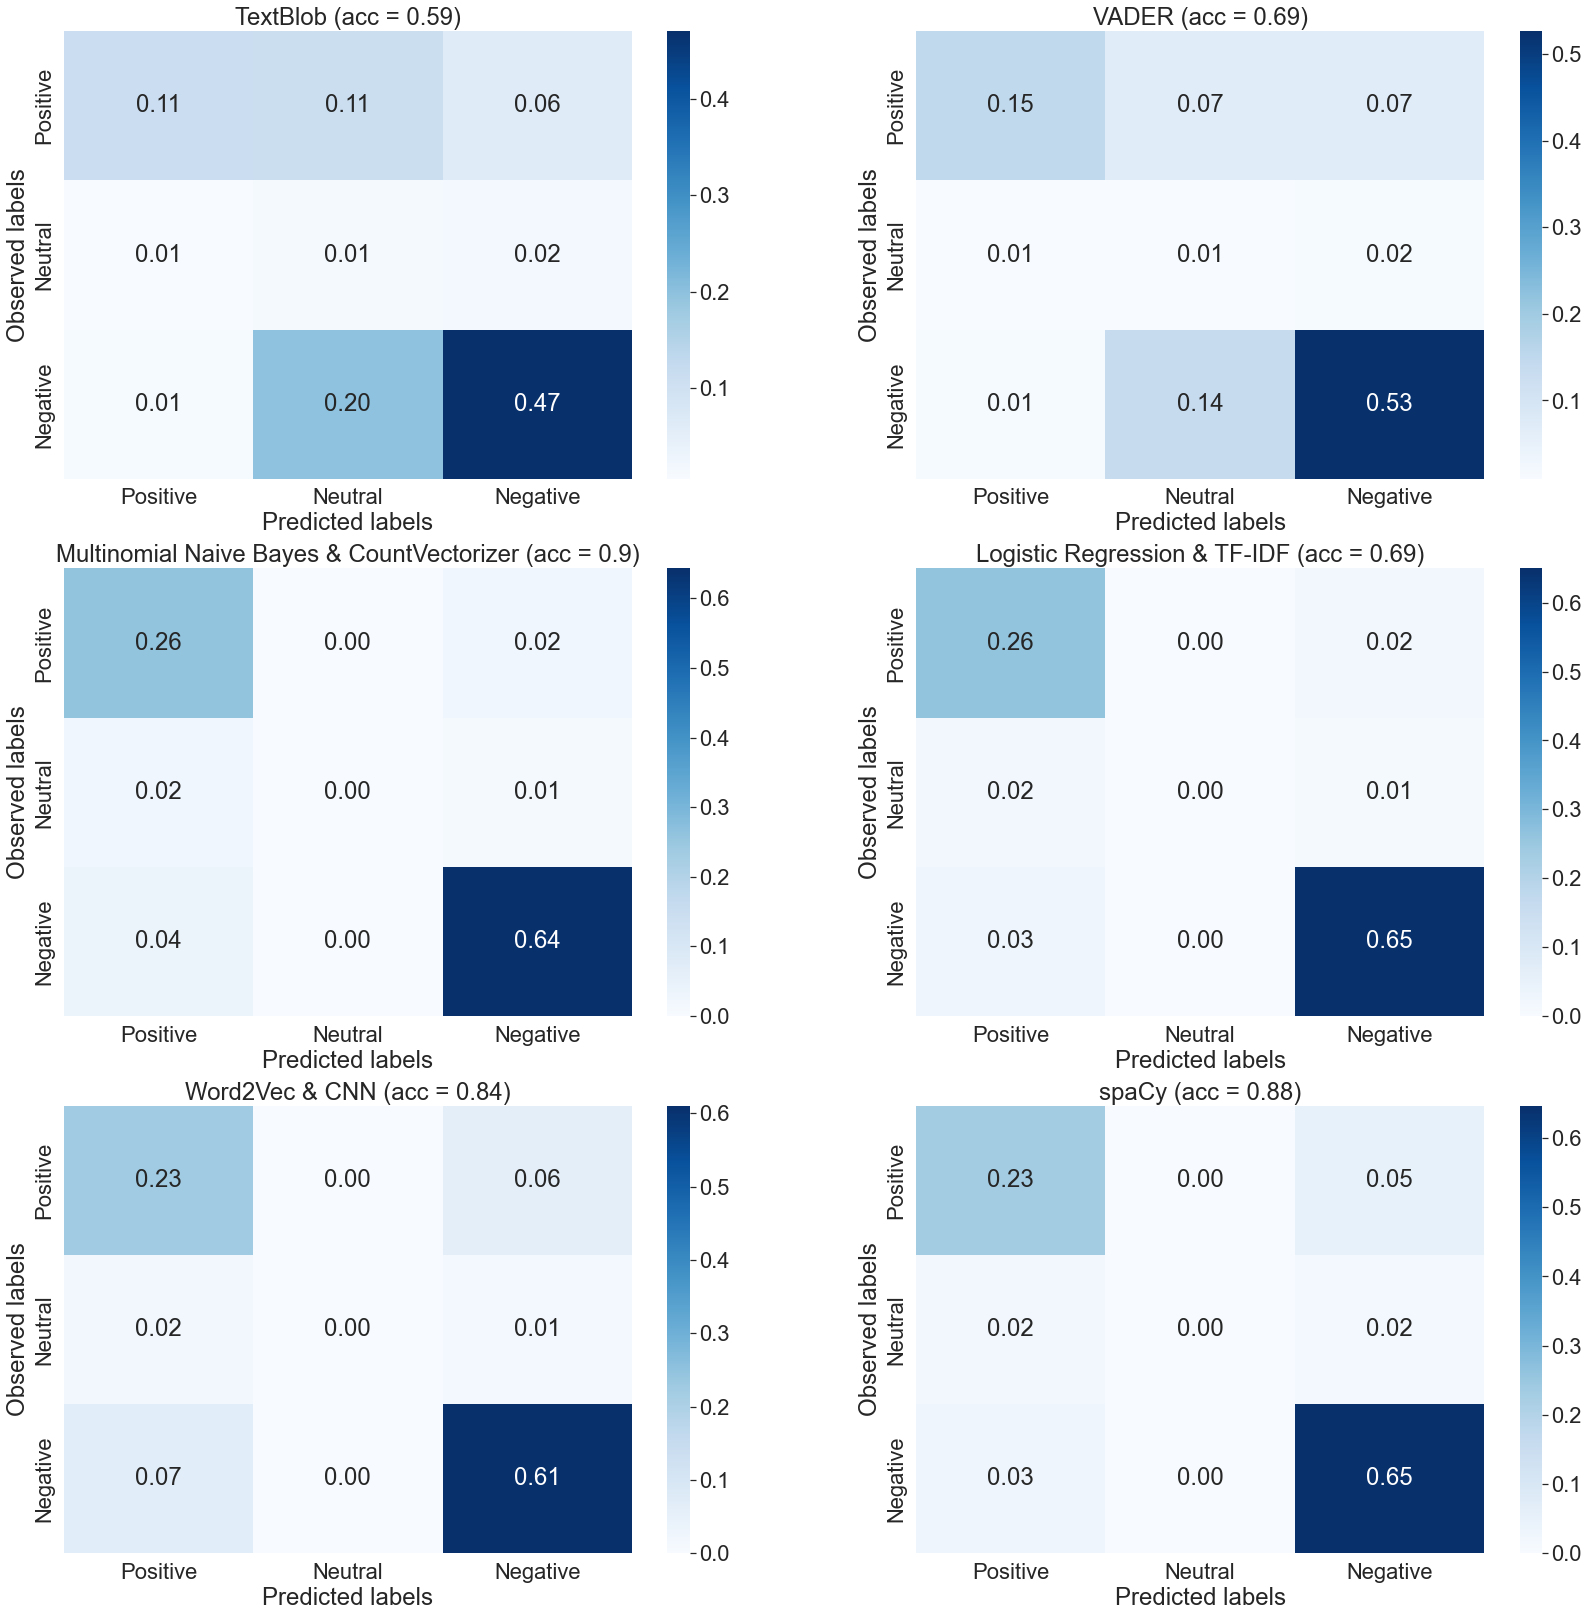

In [726]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (28, 28))
sns.set(font_scale = 2.0)

plot(y_true, uber_df['sentiment_TextBlob'], 0, 0, 'TextBlob', accuracy_textblob)
plot(y_true, uber_df['sentiment_Vader'], 0, 1, 'VADER', accuracy_vader)
plot(y_true, uber_df['sentiment_MNB'], 1, 0, 'Multinomial Naive Bayes & CountVectorizer', accuracy_MNB)
plot(y_true, uber_df['sentiment_LR'], 1, 1, 'Logistic Regression & TF-IDF', accuracy_vader)
plot(y_true, uber_df['sentiment_W2V_CNN'], 2, 0, 'Word2Vec & CNN', accuracy_CNN)
plot(y_true, uber_df['sentiment_spaCy'], 2, 1, 'spaCy', accuracy_spaCy)

In [675]:
# Evaluate the model
report_textblob = classification_report(y_true, uber_df['sentiment_TextBlob'], output_dict=True)
report_vader = classification_report(y_true, uber_df['sentiment_Vader'], output_dict=True)
report_MNB = classification_report(y_true, uber_df['sentiment_MNB'], output_dict=True)
report_LR = classification_report(y_true, uber_df['sentiment_LR'], output_dict=True)
report_W2V_CNN = classification_report(y_true, uber_df['sentiment_W2V_CNN'], output_dict=True)
report_spacy = classification_report(y_true, uber_df['sentiment_spaCy'], output_dict=True)

In [681]:
a = pd.DataFrame(report_textblob).transpose().drop(columns='support')
b = pd.DataFrame(report_vader).transpose().drop(columns='support')
c = pd.DataFrame(report_MNB).transpose().drop(columns='support')
d = pd.DataFrame(report_LR).transpose().drop(columns='support')
e = pd.DataFrame(report_spacy).transpose().drop(columns='support')
f = pd.DataFrame(report_spacy).transpose().drop(columns='support')

In [682]:
a.drop(['macro avg', 'weighted avg', 'accuracy'], inplace = True)
b.drop(['macro avg', 'weighted avg', 'accuracy'], inplace = True)
c.drop(['macro avg', 'weighted avg', 'accuracy'], inplace = True)
d.drop(['macro avg', 'weighted avg', 'accuracy'], inplace = True)
e.drop(['macro avg', 'weighted avg', 'accuracy'], inplace = True)
f.drop(['macro avg', 'weighted avg', 'accuracy'], inplace = True)

In [683]:
a['TextClassifier'] = 'TextBlob'
b['TextClassifier'] = 'VADER'
c['TextClassifier'] = 'Multinomial Naive Bayes & CountVectorizer'
d['TextClassifier'] = 'Logistic Regression & TF-IDF'
e['TextClassifier'] = 'Word2Vec & CNN'
f['TextClassifier'] = 'spaCy'

In [686]:
df = pd.concat([a, b, c, d, e, f])
df.reset_index(inplace=True)
df.rename(columns={'index':'sentiment'}, inplace = True)
df.set_index(['TextClassifier', 'sentiment'], inplace=True)
df = df.round(2)

In [710]:
df

precision  recall  \
TextClassifier                            sentiment                      
TextBlob                                  Negative        0.87    0.39   
                                          Neutral         0.04    0.38   
                                          Positive        0.85    0.69   
VADER                                     Negative        0.86    0.52   
                                          Neutral         0.05    0.30   
                                          Positive        0.86    0.78   
Multinomial Naive Bayes & CountVectorizer Negative        0.82    0.91   
                                          Neutral         1.00    0.02   
                                          Positive        0.95    0.95   
Logistic Regression & TF-IDF              Negative        0.84    0.92   
                                          Neutral         1.00    0.02   
                                          Positive        0.95    0.96   
Word2Vec & CNN                            Negative        0.82    0.82   
                                          Neutral         0.00    0.00   
                                          Positive        0.90    0.95   
spaCy                                     Negative        0.82    0.82   
                                          Neutral         0.00    0.00   
                                          Positive        0.90    0.95   

                                                     f1-score  
TextClassifier                            sentiment            
TextBlob                                  Negative       0.53  
                                          Neutral        0.08  
                                          Positive       0.77  
VADER                                     Negative       0.65  
                                          Neutral        0.09  
                                          Positive       0.82  
Multinomial Naive Bayes & CountVectorizer Negative       0.86  
                                          Neutral        0.04  
                                          Positive       0.95  
Logistic Regression & TF-IDF              Negative       0.88  
                                          Neutral        0.04  
                                          Positive       0.95  
Word2Vec & CNN                            Negative       0.82  
                                          Neutral        0.00  
                                          Positive       0.93  
spaCy                                     Negative       0.82  
                                          Neutral        0.00  
                                          Positive       0.93

In [810]:
neg = []
neu = []
pos = []

for i in range(len(df)):
    if (i%3 == 0):
        neg.append(df.iloc[i].values)
        neu.append(df.iloc[i + 1].values)
        pos.append(df.iloc[i + 2].values)


neg_precision = []
neg_recall = []
neg_f1 = []

neu_precision = []
neu_recall = []
neu_f1 = []

pos_precision = []
pos_recall = []
pos_f1 = []
for i in range(6):
    neg_precision.append(neg[i][0])
    neg_recall.append(neg[i][1])
    neg_f1.append(neg[i][2])

    neu_precision.append(neu[i][0])
    neu_recall.append(neu[i][1])
    neu_f1.append(neu[i][2])

    pos_precision.append(pos[i][0])
    pos_recall.append(pos[i][1])
    pos_f1.append(pos[i][2])


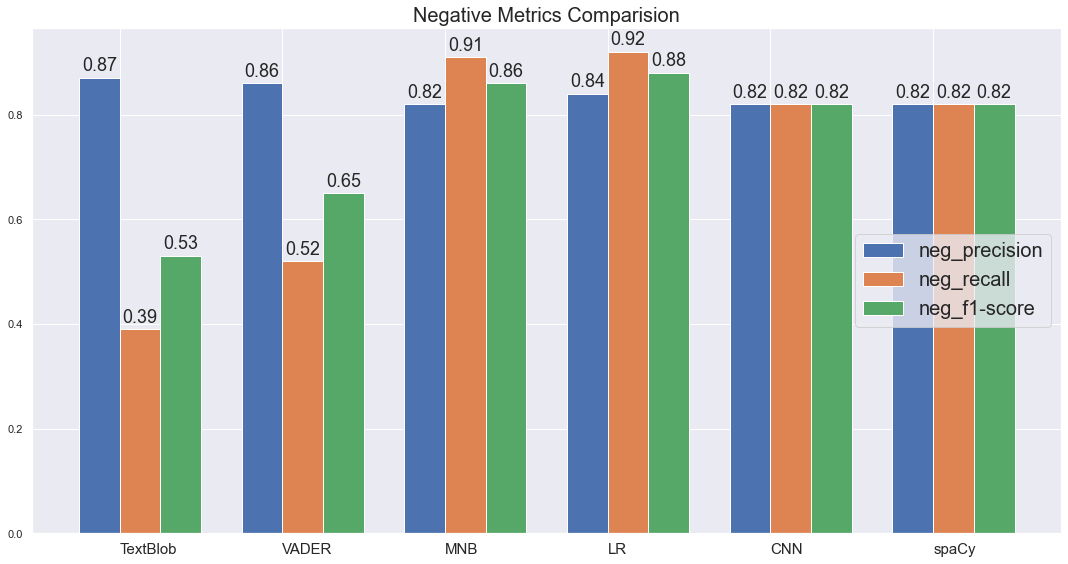

In [850]:
labels = ['TextBlob', 'VADER', 'MNB', 'LR', 'CNN', 'spaCy']
    

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (15, 8))
rects1 = ax.bar(x - width/2, neg_precision, width, label = 'neg_precision')
rects2 = ax.bar(x + width/2, neg_recall, width, label = 'neg_recall')
rects3 = ax.bar(x + width/2 + width, neg_f1, width, label = 'neg_f1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Negative Metrics Comparision', fontsize = 20)


# set amounts
ax.bar_label(rects1, padding = 3, fontsize = 18)
ax.bar_label(rects2, padding = 3, fontsize = 18)
ax.bar_label(rects3, padding = 3, fontsize = 18)


ax.set_xticks(x)
ax.set_xticklabels(labels, ha = 'left', fontsize = 15)

# PLOT
ax.legend(fontsize = 20, loc = 'center right')

fig.tight_layout()
plt.show()

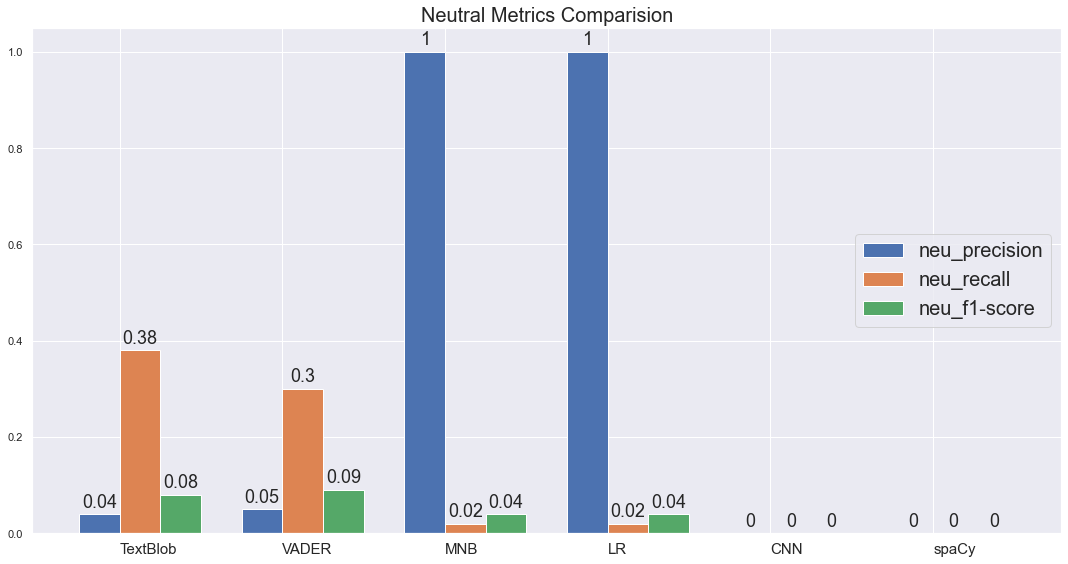

In [854]:
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (15, 8))
rects1 = ax.bar(x - width/2, neu_precision, width, label = 'neu_precision')
rects2 = ax.bar(x + width/2, neu_recall, width, label = 'neu_recall')
rects3 = ax.bar(x + width/2 + width, neu_f1, width, label = 'neu_f1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Neutral Metrics Comparision', fontsize = 20)


# set amounts
ax.bar_label(rects1, padding = 3, fontsize = 18)
ax.bar_label(rects2, padding = 3, fontsize = 18)
ax.bar_label(rects3, padding = 3, fontsize = 18)


ax.set_xticks(x)
ax.set_xticklabels(labels, ha = 'left', fontsize = 15)

# PLOT
ax.legend(fontsize = 20, loc = 'center right')

fig.tight_layout()
plt.show()

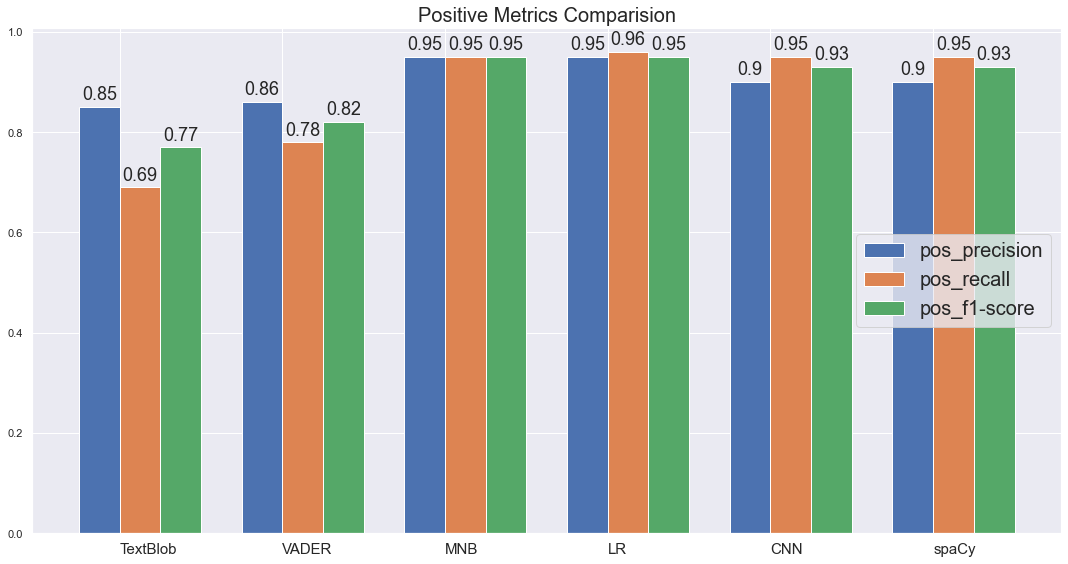

In [855]:
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (15, 8))
rects1 = ax.bar(x - width/2, pos_precision, width, label = 'pos_precision')
rects2 = ax.bar(x + width/2, pos_recall, width, label = 'pos_recall')
rects3 = ax.bar(x + width/2 + width, pos_f1, width, label = 'pos_f1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Positive Metrics Comparision', fontsize = 20)


# set amounts
ax.bar_label(rects1, padding = 3, fontsize = 18)
ax.bar_label(rects2, padding = 3, fontsize = 18)
ax.bar_label(rects3, padding = 3, fontsize = 18)


ax.set_xticks(x)
ax.set_xticklabels(labels, ha = 'left', fontsize = 15)

# PLOT
ax.legend(fontsize = 20, loc = 'center right')

fig.tight_layout()
plt.show()

## Topic Modeling

In [956]:
comment = uber_df.reset_index(drop = True)['content'].astype(str)

### Top words appearance in total comments

In [873]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

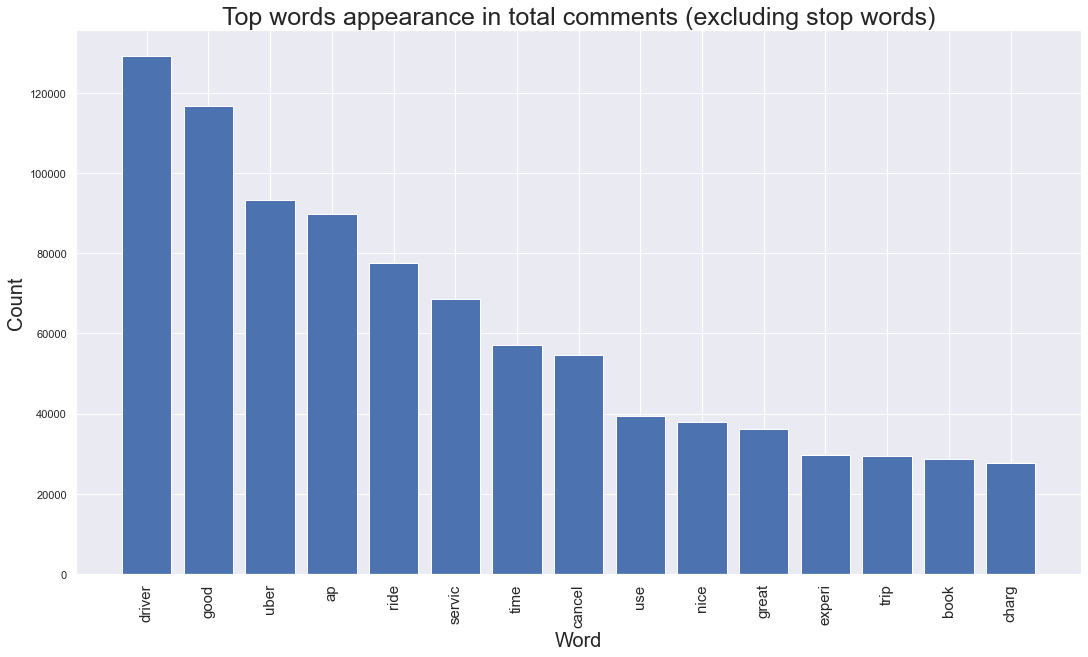

In [874]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words = 15,
                                     count_vectorizer = count_vectorizer, 
                                     text_data = comment)

fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation = 90, fontsize = 15)
ax.set_title('Top words appearance in total comments (excluding stop words)', fontsize = 25)
ax.set_xlabel('Word', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
plt.show()

### Part-of-speech Tagging

In [875]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [950]:
tagged_comments = [TextBlob(comment[i]).pos_tags for i in range(comment.shape[0])]

In [951]:
tagged_comments_df = pd.DataFrame({'tags':tagged_comments})

word_counts = []    # 1. Number of words each sentences
pos_counts = {}     # 2. Part-of-speech tagging

for comment in tagged_comments_df[u'tags']:
    word_counts.append(len(comment))
    for tag in comment:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per comment: ', np.mean(word_counts))

Total number of words:  3571229
Mean number of words per comment:  7.143072304218163


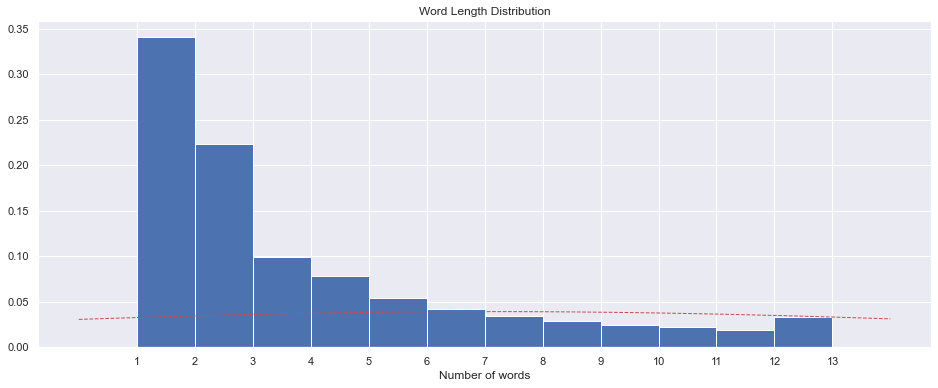

In [952]:
y = st.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(16, 6))
ax.hist(word_counts, bins=range(1,14), density=True)
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1)
ax.set_title('Word Length Distribution')
ax.set_xticks(range(1,14))
ax.set_xlabel('Number of words')
plt.show()

In [957]:
# CountVectorizer
small_count_vectorizer = CountVectorizer(max_features = 40000)

# Random Sampling
small_text_sample = comment.sample(n = 10000, random_state = 0).values

# Headline Vectorizer
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Comment before vectorization: {}'.format(small_text_sample[1]))
print('Comment after vectorization: \n{}'.format(small_document_term_matrix[1]))

Comment before vectorization: good ap
Comment after vectorization: 
  (0, 2161)	1
  (0, 252)	1


### Topic Modeling

In [958]:
n_topics = 8

In [959]:
# return an integer list of predicted topic categories for a given topic matrix
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys


# return a tuple of topic categories and their accompanying magnitudes for a given list of keys
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [960]:
lda_model = LatentDirichletAllocation(n_components = n_topics, learning_method = 'online', 
                                          random_state = 0, verbose = 0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [961]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [962]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}:".format(i + 1), top_n_words_lda[i])

Topic 1: excel driver best servic friend ap help polit wonder uber
Topic 2: great ap hai servic que de driver ride uber experi
Topic 3: good servic awesom driver ap nice experi super drive car
Topic 4: uber love use ap thank much driver servic ride account
Topic 5: driver ap nice uber time ride experi charg bad show
Topic 6: driver ride uber ap cancel time servic get trip book
Topic 7: superb uber perfect servic hai ap mm clean driver nyc
Topic 8: use easi alway fast safe ride uber driver ok conveni


Text(0, 0.5, 'Number of words')

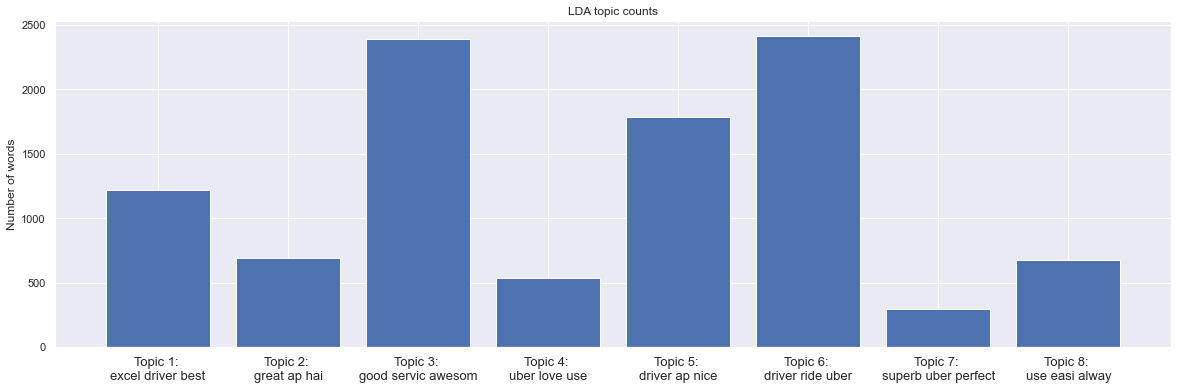

In [963]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i + 1) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(lda_categories, lda_counts)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels, fontsize = 13)
ax.set_title('LDA topic counts')
ax.set_ylabel('Number of words')